# Segmentando o ventrículo esquerdo com a rede U-Net

Nesta aplicação a rede U-Net é utilizada como segmentadora do ventrículo esquerdo do coração.

A tarefa de segmentação é um dos passos para uma solução para a competição do Kaggle "Second Annual Data Science Bowl" (https://www.kaggle.com/c/second-annual-data-science-bowl)

O dataset utilizado (https://github.com/juliandewit/kaggle_ndsb2/tree/master/data_segmenter_trainset) foi gerado pelo terceiro colocado na competição e contém **9282 imagens e 9282 segmentos** de 184x184 pixels gerados manualmente.

A rede é treinada com a imagem do ventrículo esquerdo do coração coo entrada e a máscara da área segmentada como saída.

O notebook é organizado da seguinte forma:
- importação das bibliotecas
- leitura e tratamento do dataset
- criação da rede
- treinamento da rede
- avaliação da rede com imagens de diversos tamanhos

## Importação das bibliotecas

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

# image and file libs
from PIL import Image
import IPython.display
from pandas.io.parsers import read_csv

# from os
import os.path

# from torch
import torch
from torch import nn
from torch.autograd import Variable

# from torchvision
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# from course libs
import lib.pytorch_trainer as ptt

In [2]:
# verifica se a GPU esta disponivel
use_gpu = torch.cuda.is_available()
print("Usando GPU:", use_gpu)

Usando GPU: True


## Leitura do Dataset

### Classe do dataloader

In [3]:
class SegmenterDataset(Dataset):
    def __init__(self, root_dir, demo=True, split=None, transform=None):
        self.image_dir = os.path.join(root_dir, "image")
        self.segment_dir = os.path.join(root_dir, "segment")
        if demo:
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_demo.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_demo.csv"), header=None).T
        elif split == "Train":
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_train.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_train.csv"), header=None).T
        elif split == "Validate":
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image_validate.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment_validate.csv"), header=None).T
        else:
            self.image_list = read_csv(os.path.join(
                self.image_dir,"image.csv"), header=None).T
            self.segment_list = read_csv(os.path.join(
                self.segment_dir,"segment.csv"), header=None).T
        self.image_list = self.image_list.as_matrix().reshape(-1,)
        self.segment_list = self.segment_list.as_matrix().reshape(-1,)
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        segment_name = self.segment_list[idx]
        image_path = os.path.join(self.image_dir, image_name)
        segment_path = os.path.join(self.segment_dir, segment_name)

        image = Image.open(image_path)
        segment = Image.open(segment_path)

        if self.transform:
            image = self.transform(image)
            segment = self.transform(segment)

        return image, segment

### Carregando dados de exemplo

In [4]:
# diretório dos dados
dataset_dir = '/data/datasets/heart_image_segmenter/'

segmenter_dataset = SegmenterDataset(dataset_dir, transform=transforms.ToTensor())

### Mostrando algumas imagens do conjunto de treinamento

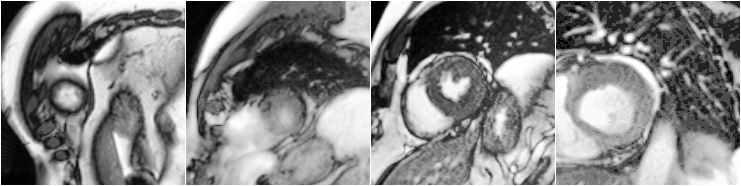

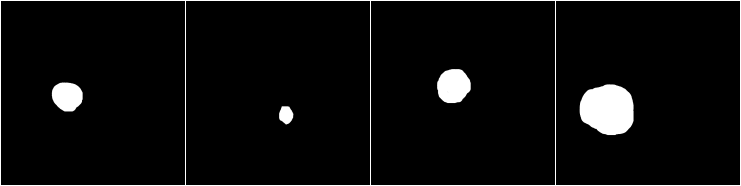

In [6]:
n_samples = 4
tensor2pil = transforms.ToPILImage()

# cria um DataLoader temporario para pegar um batch de 'n_samples' imagens de treinamento
temp_dataloader = torch.utils.data.DataLoader(segmenter_dataset, 
                                              batch_size = n_samples,
                                              shuffle=True, num_workers=4)

# pega um batch de imagens
image_batch, masks = next(iter(temp_dataloader))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch, normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
IPython.display.display(img_pil)
# cria um grid com as máscaras
grid = torchvision.utils.make_grid(masks, normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
IPython.display.display(img_pil)

In [7]:
del segmenter_dataset
del temp_dataloader

### Criando DataLoader para o treinamento da rede

In [8]:
batch_size = 5

train_segmenter_dataset = SegmenterDataset(
                            dataset_dir,
                            demo=False, split="Train",
                            transform=transforms.ToTensor())

train_segmenter_loader = torch.utils.data.DataLoader(
                                        train_segmenter_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        pin_memory=True)

validate_segmenter_dataset = SegmenterDataset(
                            dataset_dir,
                            demo=False, split="Validate",
                            transform=transforms.ToTensor())

validate_segmenter_loader = torch.utils.data.DataLoader(
                                        validate_segmenter_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        pin_memory=True)

## Criação da rede

<img src='../figures/u-net-architecture.png', width=900pt></img>

O U-Net é uma arquitetura de rede convolucional para segmentação rápida e precisa de imagens. Mais detalhes podem ser vistos em https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/

In [9]:
import torch.nn.functional as F

class ConvBlock(torch.nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=1, stride=1):
        super(ConvBlock, self).__init__()
        self.conv = torch.nn.Conv2d(in_size, out_size, kernel_size,
                              padding=padding, stride=stride)
        self.bn = torch.nn.BatchNorm2d(out_size)
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

# classe UNet
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_1 = torch.nn.Sequential(
            ConvBlock(1, 16),
            ConvBlock(16, 32, stride=2, padding=1))

        self.down_2 = torch.nn.Sequential(
            ConvBlock(32, 64),
            ConvBlock(64, 128))

        self.middle = ConvBlock(128, 128, kernel_size=1, padding=0)

        self.up_2 = torch.nn.Sequential(
            ConvBlock(256, 128),
            ConvBlock(128, 32))

        self.up_1 = torch.nn.Sequential(
            ConvBlock(64, 64),
            ConvBlock(64, 32))

        self.output = torch.nn.Sequential(
            ConvBlock(32, 16),
            ConvBlock(16, 1, kernel_size=1, padding=0))

    def forward(self, x):
        down1 = self.down_1(x)
        out = F.max_pool2d(down1, kernel_size=2, stride=2)

        down2 = self.down_2(out)
        out = F.max_pool2d(down2, kernel_size=2, stride=2)

        out = self.middle(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down2, out], 1)
        out = self.up_2(out)

        out = F.upsample(out, scale_factor=2)
        out = torch.cat([down1, out], 1)
        out = self.up_1(out)

        out = F.upsample(out, scale_factor=2)
        return self.output(out)

### Rede U-Net

In [10]:
model_segmenter = UNet()
if use_gpu:
    model_segmenter.cuda()

### Sumário da rede

In [11]:
print(model_segmenter)

UNet(
  (down_1): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
  )
  (down_2): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
    )
  )
  (middle): ConvBlock(
    (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1

## Treinamento

### Criando o objeto de treinamento

In [12]:
optimizer = torch.optim.Adam(model_segmenter.parameters())
criterion = nn.MSELoss()
savebest = ptt.ModelCheckpoint('../../models/model_segmenter',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
    model       = model_segmenter,
    criterion   = criterion, 
    optimizer   = optimizer,
    callbacks   = [ptt.PrintCallback(),savebest]
)

In [13]:
train = False
if train:
    trainer.fit_loader(25, train_data=train_segmenter_loader, valid_data=validate_segmenter_loader)
else:
    trainer.load_state('/data/models/model_segmenter')

Start training for 25 epochs
  1:  31.2s   T: 0.00969   V: 0.00783 best
  2:  29.5s   T: 0.00558   V: 0.00596 best
  3:  29.5s   T: 0.00468   V: 0.00535 best
  4:  29.9s   T: 0.00417   V: 0.00439 best
  5:  29.2s   T: 0.00380   V: 0.00493 
  6:  29.2s   T: 0.00354   V: 0.00611 
  7:  29.2s   T: 0.00337   V: 0.00436 best
  8:  29.2s   T: 0.00318   V: 0.00448 
  9:  29.2s   T: 0.00307   V: 0.00466 
 10:  29.3s   T: 0.00297   V: 0.00432 best
 11:  29.3s   T: 0.00285   V: 0.00416 best
 12:  29.2s   T: 0.00275   V: 0.00431 
 13:  29.2s   T: 0.00264   V: 0.00431 
 14:  29.2s   T: 0.00260   V: 0.00465 
 15:  29.2s   T: 0.00250   V: 0.00417 
 16:  29.2s   T: 0.00243   V: 0.00416 
 17:  29.2s   T: 0.00238   V: 0.00436 
 18:  29.2s   T: 0.00228   V: 0.00435 
 19:  29.2s   T: 0.00226   V: 0.00443 
 20:  29.3s   T: 0.00217   V: 0.00448 
 21:  29.2s   T: 0.00213   V: 0.00420 
 22:  29.3s   T: 0.00203   V: 0.00440 
 23:  29.2s   T: 0.00199   V: 0.00533 
 24:  29.2s   T: 0.00194   V: 0.00455 
 25:  2

Treinamento em uma GPU Nvidia Geforce 1080Ti:

    Start training for 25 epochs
      1:  30.2s   T: 0.01337   V: 0.00851 best
      2:  29.3s   T: 0.00598   V: 0.00619 best
      3:  29.4s   T: 0.00503   V: 0.00514 best
      4:  29.3s   T: 0.00444   V: 0.00561 
      5:  29.3s   T: 0.00413   V: 0.00483 best
      6:  29.3s   T: 0.00378   V: 0.00550 
      7:  29.5s   T: 0.00362   V: 0.00498 
      8:  29.5s   T: 0.00336   V: 0.00479 best
      9:  29.4s   T: 0.00325   V: 0.00440 best
     10:  30.0s   T: 0.00316   V: 0.00452 
     11:  30.5s   T: 0.00302   V: 0.00493 
     12:  30.3s   T: 0.00291   V: 0.00437 best
     13:  31.8s   T: 0.00281   V: 0.00507 
     14:  29.7s   T: 0.00269   V: 0.00434 best
     15:  30.1s   T: 0.00265   V: 0.00551 
     16:  30.2s   T: 0.00258   V: 0.00941 
     17:  29.4s   T: 0.00250   V: 0.00418 best
     18:  29.4s   T: 0.00243   V: 0.00464 
     19:  29.4s   T: 0.00234   V: 0.00420 
     20:  29.4s   T: 0.00231   V: 0.00416 best
     21:  29.8s   T: 0.00223   V: 0.00482 
     22:  29.5s   T: 0.00220   V: 0.00431 
     23:  29.4s   T: 0.00213   V: 0.00436 
     24:  29.5s   T: 0.00206   V: 0.00413 best
     25:  29.6s   T: 0.00202   V: 0.00480 
    Stop training at epoch: 25/25
    Best model was saved at epoch 24 with loss 0.00413: ../../models/model_segmenter


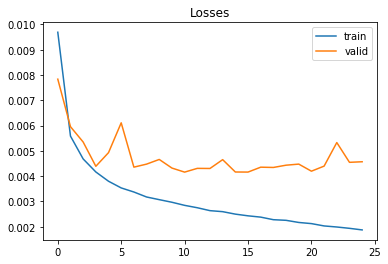

In [14]:
train_loss = trainer.metrics['train']['losses']
valid_loss = trainer.metrics['valid']['losses']
epochs = np.arange(len(train_loss))
plt.plot(epochs, train_loss, label='train')
plt.plot(epochs, valid_loss, label='valid')
plt.legend()
plt.title('Losses')
plt.show()

## Avaliação

### Prevendo saída do conjunto de testes

In [15]:
n_samples = 4
segmenter_dataset = SegmenterDataset(dataset_dir, demo=False, split="Validate", transform=transforms.ToTensor())
segmenter_loader = torch.utils.data.DataLoader(
                                        segmenter_dataset,
                                        batch_size=n_samples,
                                        shuffle=False,
                                        pin_memory=True)

In [16]:
prediction = trainer.predict_loader(segmenter_loader) # 40 segundos na AWS

### Transformando saída em máscara binária

In [17]:
prediction_numpy = prediction.numpy()

In [18]:
prediction_mask = np.zeros((prediction_numpy.shape))

In [19]:
threshold = 0.5
prediction_mask[prediction_numpy > threshold] = 1.

### Avaliando qualidade das máscaras

O coeficiente **Dice**, ou índice de **Sørensen**, é uma estatística usada para comparar a semelhança entre duas amostras.

A fórmula original de Sørensen tem por objetivo medir a presença/ausência de dados e é dada por:

$$S = \frac{2|X \cap Y|}{|X| + |Y|},$$

no qual |X| e |Y| elementos das amostras que se deseja comparar.

O coeficiente Dice é comumente usado para avaliação de segmentação de imagens, como por exemplo, comparar a saída do algoritmo com máscaras de referência em aplicações médicas.

In [20]:
def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [21]:
dice_total = 0
dice_list = np.zeros((len(prediction_numpy),2))
for i in range(len(prediction_mask)):
    dice_list[i][0] = i
    dice_list[i][1] = dice_loss(segmenter_dataset[i][1], torch.Tensor(prediction_mask[i])) 
    dice_total += dice_list[i][1]
dice_total /= len(prediction_mask)

Dice total das amostras previstas

In [22]:
dice_total

0.8741988679650282

Ordena a lista por ordem de coeficiente Dice

In [23]:
dice_list = dice_list[dice_list[:,1].argsort()]

### Mostrando as 4 primeiras amostras do conjunto de teste

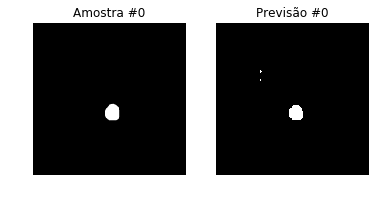

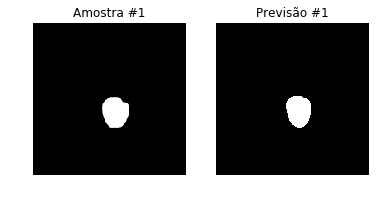

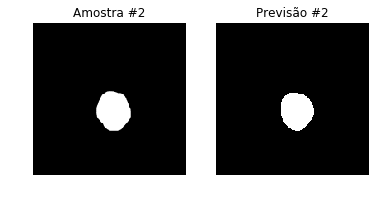

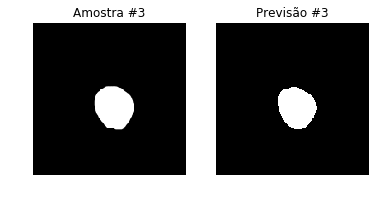

In [24]:
for i in range(4):
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Amostra #'+str(i))
    ax.axis('off')
    plt.imshow(segmenter_dataset[i][1].numpy().squeeze(), cmap='gray')
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Previsão #'+str(i))
    ax.axis('off')
    plt.imshow(prediction_mask[i].squeeze(), cmap='gray')
    plt.show()

### Mostrando as 4 amostras com menor Dice

 Dice:0.0019944780300140035


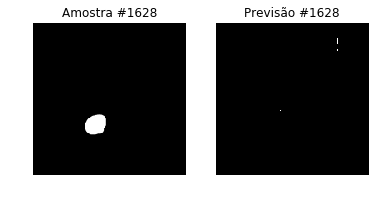

 Dice:0.0021801579929707953


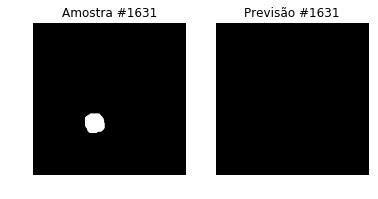

 Dice:0.002353201734727656


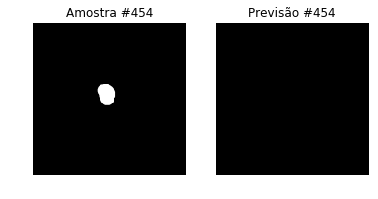

 Dice:0.002713632005135069


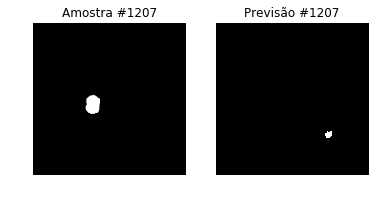

In [25]:
for i in range(4):
    print(" Dice:"+str(dice_list[i][1]))
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Amostra #'+str(int(dice_list[i][0])))
    ax.axis('off')
    plt.imshow(segmenter_dataset[int(dice_list[i][0])][1].numpy().squeeze(), cmap='gray')
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Previsão #'+str(int(dice_list[i][0])))
    ax.axis('off')
    plt.imshow(prediction_mask[int(dice_list[i][0])].squeeze(), cmap='gray')
    plt.show()

### Mostrando as 4 amostras com maior Dice

 Dice:0.9835580745980806


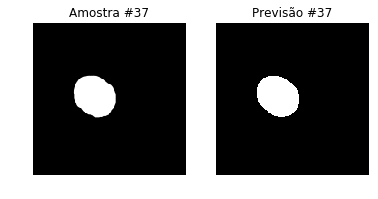

 Dice:0.9829088332014247


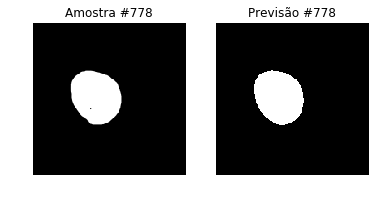

 Dice:0.98290072763038


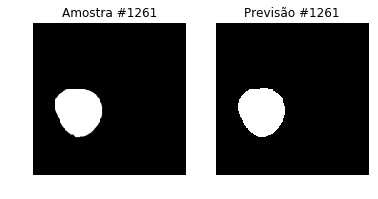

 Dice:0.9809699831162243


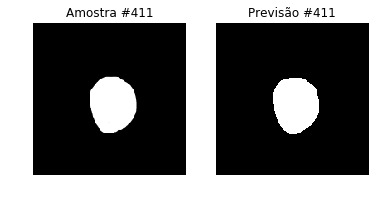

In [26]:
dice_list_reversed = dice_list[::-1]
for i in range(4):
    print(" Dice:"+str(dice_list_reversed[i][1]))
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Amostra #'+str(int(dice_list_reversed[i][0])))
    ax.axis('off')
    plt.imshow(segmenter_dataset[int(dice_list_reversed[i][0])][1].numpy().squeeze(), cmap='gray')
    ax = plt.subplot(1, 2, 2)
    ax.set_title('Previsão #'+str(int(dice_list_reversed[i][0])))
    ax.axis('off')
    plt.imshow(prediction_mask[int(dice_list_reversed[i][0])].squeeze(), cmap='gray')
    plt.show()

### Plot da imagem original do coração com a previsão do segmento

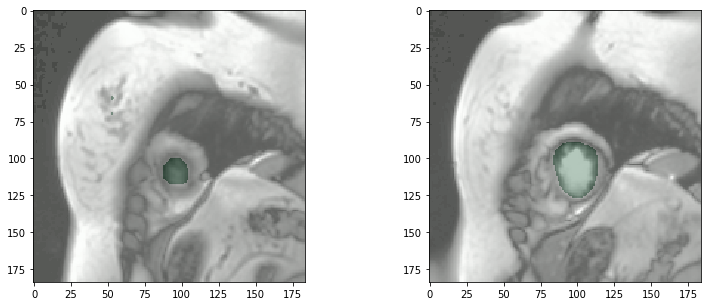

In [27]:
fig = plt.figure(figsize=(13,5))

ax = plt.subplot(1, 2, 1)
plt.imshow(segmenter_dataset[0][0].numpy().squeeze(), cmap='gray')
plt.imshow(prediction_mask[0].squeeze(), cmap='Greens', alpha=0.3)
ax = plt.subplot(1, 2, 2)
plt.imshow(segmenter_dataset[1][0].numpy().squeeze(), cmap='gray')
plt.imshow(prediction_mask[1].squeeze(), cmap='Greens', alpha=0.3)
plt.show()

## Exercícios

## Aprendizados